In [72]:
import torch
import os
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

bundle = torchaudio.pipelines.WAV2VEC2_LARGE
model_extr = bundle.get_model().to(device)

main_path = '/home/wawa_/'

emotion_map = {'Neutre': 'neutral', 'Colère': 'angry', 'Joie': 'happy', 'Tristesse': 'sad', 'Peur': 'fear',
              'Dégoût': 'disgust', 'Surprise': 'surprise'}

model_name = 'Wav2Vec2Large' 
model_folder = model_name

1.12.1
0.12.1+cu113
cuda


## Generate features (run once)

In [74]:
# import os

# data_path = '/home/wawa_/CaFE/High resolution (192kHz)/'
# folders = ['Joie', 'Peur', 'Tristesse', 'Colère', 'Dégoût', 'Neutre', 'Surprise']
# audios = []
# labels = []
# file_paths = []
# for folder in folders:
#   if folder!='Neutre':
#     subfolders = ['Fort/', 'Faible/']
#   else:
#     subfolders = ['']
#   for subfolder in subfolders:
#     dir_path = data_path + folder + '/' + subfolder
#     for file in os.listdir(dir_path):
#         if 'aiff' not in file:
#             continue
#         name = file.split('.')[0]
#         file_path = dir_path + file
#         labels.append(folder)
#         wave, sr = torchaudio.load(file_path)
#         wave = wave.to(device)
#         if sr != bundle.sample_rate:
#             wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
  
#         with torch.inference_mode():
#             feature, _ = model_extr.extract_features(wave)
#         feature = [f[0] for f in feature]
#         feature = torch.stack(feature)
#         save_path_folder = f'/home/wawa_/data/{model_folder}/{folder}/{subfolder}'
#         os.makedirs(save_path_folder, exist_ok = True) 
#         save_path = f'/home/wawa_/data/{model_folder}/{folder}/{subfolder}{name}.pt'
#         torch.save(feature, save_path)


## Load Data

In [75]:
import pandas as pd

# Get the entries with assigned session
dataframe_path = main_path + 'session_entries.csv'
file = pd.read_csv(dataframe_path)[['path', 'feat_path', 'name', 'emotion', 'strength', 'session']]
file = file[file['strength'] == 'Fort']

# #### If on low_res data:
# def fix_path(path):
#     path2 = path.split('/')
#     if path2[-1][3]=='N':
#         path2[-1] = path2[-1][:5] + '1-' + path2[-1][5:]
#     return '/'.join(path2)

# def fix_name(name):
#     if name[3]=='N':
#         return name[:5] + '1-' + name[5:]
#     else:
#         return name

# file['path'] = file['path'].map(fix_path)
# file['feat_path'] = file['feat_path'].map(fix_path)
# file['name'] = file['name'].map(fix_name)

#### Corrects path of data:
def fix_path(path):
    global model_folder
    path2 = path.split('/')
    path2[4] = model_folder
    return '/'.join(path2)

file['feat_path'] = file['feat_path'].map(fix_path)

file.head()

,path,feat_path,name,emotion,strength,session
0,/home/wawa_/CaFE/High resolution (192kHz)/Dégo...,/home/wawa_/data/Wav2Vec2Large/Dégoût/Fort/03-...,03-D-2-2.aiff,disgust,Fort,1
1,/home/wawa_/CaFE/High resolution (192kHz)/Neut...,/home/wawa_/data/Wav2Vec2Large/Neutre/01-N-3.pt,01-N-3.aiff,neutral,Fort,1
2,/home/wawa_/CaFE/High resolution (192kHz)/Tris...,/home/wawa_/data/Wav2Vec2Large/Tristesse/Fort/...,02-T-2-6.aiff,sad,Fort,1
4,/home/wawa_/CaFE/High resolution (192kHz)/Surp...,/home/wawa_/data/Wav2Vec2Large/Surprise/Fort/0...,08-S-2-6.aiff,surprise,Fort,1
5,/home/wawa_/CaFE/High resolution (192kHz)/Tris...,/home/wawa_/data/Wav2Vec2Large/Tristesse/Fort/...,09-T-2-5.aiff,sad,Fort,1


In [84]:
from tqdm import tqdm

holdout = 2
train_audios = []
test_audios = []
train_emotions = []
test_emotions = []

for _, row in tqdm(file.iterrows()):
    audio = torch.load(row['feat_path'])
    audio = torch.mean(audio, dim=1, keepdim=False)
    emotion = row['emotion']
    if row['session'] != holdout:
        train_audios.append(audio)
        train_emotions.append(emotion)
    else:
        test_audios.append(audio)
        test_emotions.append(emotion)
    

504it [00:05, 85.24it/s]


In [85]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, datas, labels, label_transform):
        super(MyDataSet).__init__()
        self.datas = datas
        self.labels = labels
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.datas[idx]
        label = self.label_transform[self.labels[idx]]
        return audio, label
    
    def __len__(self):
        return len(self.labels)

In [86]:
categories = ['neutral', 'angry', 'happy', 'sad', 'fear', 'disgust', 'surprise']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'neutral': 0,
 'angry': 1,
 'happy': 2,
 'sad': 3,
 'fear': 4,
 'disgust': 5,
 'surprise': 6}

## Model

In [87]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, label_size=7):
        super().__init__()
        self.nn = nn.Linear(in_features = vocab_size, out_features = hidden_size)
        self.linear = nn.Linear(in_features = hidden_size, out_features = label_size)

    def forward(self, x):
        x = self.nn(x)
        logits = self.linear(x)
        return logits

In [88]:
from torch.utils.data import DataLoader
import torch.optim as optim

layers = len(train_audios[0]) #12 for Base models, 24 for Large models
test_accuracies = []
for layer in range(layers):
    train = torch.stack([x[layer] for x in train_audios])
    test = torch.stack([x[layer] for x in test_audios])
    train_dataset = MyDataSet(train, train_emotions, cate_dic)
    trainloader_args = dict(batch_size=64, shuffle=True)
    train_dataloader = DataLoader(train_dataset, **trainloader_args)
    
    if layers == 12:
        model = NN(768, 128, 7)
    elif layers == 24:
        model = NN(1024, 128, 7)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 50
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        acc_cnt = 0
        err_cnt = 0
        batch_cnt = 0
        model.train()
        for batch, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().item()

            #model outputs
            out_val, out_indices = torch.max(logits, dim=1)
            tar_indices = y

            for i in range(len(out_indices)):
                if out_indices[i] == tar_indices[i]:
                    acc_cnt += 1
                else:
                    err_cnt += 1
            batch_cnt += 1

        train_loss = train_loss/batch_cnt
        train_accuracy = acc_cnt/(acc_cnt+err_cnt)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        
    test_dataset = MyDataSet(test, test_emotions, cate_dic)
    testloader_args = dict(batch_size=1, shuffle=True)
    test_dataloader = DataLoader(test_dataset, **testloader_args)

    test_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)
        test_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1

    test_loss = test_loss/batch_cnt
    test_accuracy = acc_cnt/(acc_cnt+err_cnt)
    print(f'layer: {layer}, test accuracy: {test_accuracy}')
    test_accuracies.append(test_accuracy)

100%|██████████| 50/50 [00:01<00:00, 44.94it/s]


layer: 0, test accuracy: 0.8172043010752689


100%|██████████| 50/50 [00:01<00:00, 45.89it/s]


layer: 1, test accuracy: 0.8387096774193549


100%|██████████| 50/50 [00:01<00:00, 45.73it/s]


layer: 2, test accuracy: 0.8924731182795699


100%|██████████| 50/50 [00:01<00:00, 45.54it/s]


layer: 3, test accuracy: 0.8494623655913979


100%|██████████| 50/50 [00:01<00:00, 46.47it/s]


layer: 4, test accuracy: 0.8494623655913979


100%|██████████| 50/50 [00:01<00:00, 46.12it/s]


layer: 5, test accuracy: 0.8924731182795699


100%|██████████| 50/50 [00:01<00:00, 46.38it/s]


layer: 6, test accuracy: 0.9354838709677419


100%|██████████| 50/50 [00:01<00:00, 46.19it/s]


layer: 7, test accuracy: 0.9139784946236559


100%|██████████| 50/50 [00:01<00:00, 45.71it/s]


layer: 8, test accuracy: 0.9032258064516129


100%|██████████| 50/50 [00:01<00:00, 46.20it/s]


layer: 9, test accuracy: 0.9139784946236559


100%|██████████| 50/50 [00:01<00:00, 46.89it/s]


layer: 10, test accuracy: 0.9139784946236559


100%|██████████| 50/50 [00:01<00:00, 46.08it/s]


layer: 11, test accuracy: 0.8817204301075269


100%|██████████| 50/50 [00:01<00:00, 45.98it/s]


layer: 12, test accuracy: 0.9032258064516129


100%|██████████| 50/50 [00:01<00:00, 46.87it/s]


layer: 13, test accuracy: 0.8817204301075269


100%|██████████| 50/50 [00:01<00:00, 46.72it/s]


layer: 14, test accuracy: 0.946236559139785


100%|██████████| 50/50 [00:01<00:00, 47.03it/s]


layer: 15, test accuracy: 0.9247311827956989


100%|██████████| 50/50 [00:01<00:00, 48.17it/s]


layer: 16, test accuracy: 0.9247311827956989


100%|██████████| 50/50 [00:01<00:00, 46.05it/s]


layer: 17, test accuracy: 0.946236559139785


100%|██████████| 50/50 [00:01<00:00, 45.30it/s]


layer: 18, test accuracy: 0.9139784946236559


100%|██████████| 50/50 [00:01<00:00, 46.39it/s]


layer: 19, test accuracy: 0.9139784946236559


100%|██████████| 50/50 [00:01<00:00, 45.98it/s]


layer: 20, test accuracy: 0.8279569892473119


100%|██████████| 50/50 [00:01<00:00, 46.52it/s]


layer: 21, test accuracy: 0.7419354838709677


100%|██████████| 50/50 [00:01<00:00, 47.57it/s]


layer: 22, test accuracy: 0.3763440860215054


100%|██████████| 50/50 [00:01<00:00, 46.51it/s]

layer: 23, test accuracy: 0.3118279569892473


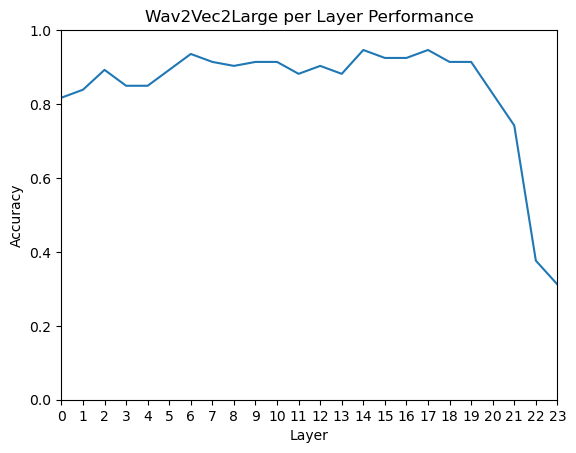

In [93]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(layers), test_accuracies)
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.axis([0, layers-1, 0, 1])
plt.xticks(np.arange(0, layers, 1))
plt.title(f"{model_name} per Layer Performance")
plt.show()

In [90]:
res = pd.DataFrame({'layer': range(layers), 'accuracy': test_accuracies})

In [91]:
os.makedirs(f'csv_results/', exist_ok = True) 

res.to_csv(f'csv_results/{model_name}_perlayer.csv', index=False)
res

,layer,accuracy
0,0,0.817204
1,1,0.838710
2,2,0.892473
3,3,0.849462
4,4,0.849462
5,5,0.892473
6,6,0.935484
7,7,0.913978
8,8,0.903226
9,9,0.913978
